# Key Features
    # Learning & Content Creation:
        # Offers tailored learning pathways in GenAI, covering key topics and skills.
        # Assists users in creating tutorials, blogs, and posts based on their interests or queries.

    # Q&A Support:
        # Provides on-demand Q&A sessions for users needing guidance on concepts or coding issues.

    # Resume Building & Review:
        # One-on-one resume consultations and guidance.
        # Crafts personalized, market-relevant resumes optimized for current job trends.

    # Interview Preparation:
        # Hosts Q&A sessions on common and technical interview questions.
        # Simulates real interview scenarios and conducts mock interviews.

    # Job Search Assistance:
        # Guides users through the job search process, offering tailored insights and support. With the GenAI Career Assistant, your journey to a career in Generative AI becomes organized, personalized, and efficient!



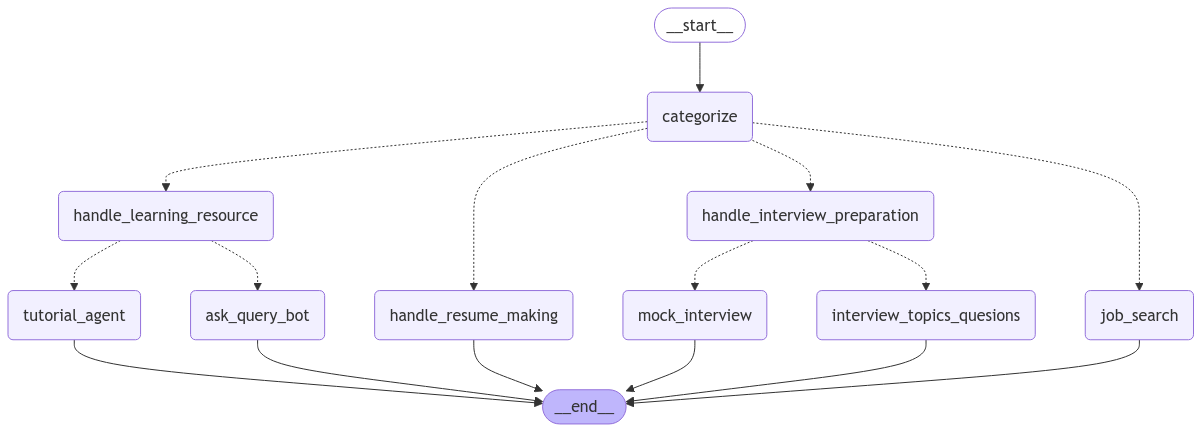

In [19]:
%pip install langchain==0.3.7 langchain-community==0.3.7 langchain_google_genai==2.0.4 duckduckgo_search==6.3.4 langgraph==0.2.48 python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END, START #Importing StateGraph, END, and START from langgraph.graph to define and manage state transitions within a conversational or generative AI workflow.
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod # to visualize the graph of langgraph node and edges
from dotenv import load_dotenv
import os

# Load environment variables from a .env file to access sensitive information
load_dotenv()

# Set the Gemini API key for authentication with Google Generative AI services
os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')

# Instantiate a chat model using Google's Gemini-1.5-flash with specified configurations
# - verbose=True enables detailed output logs for debugging
# - temperature=0.5 controls the creativity level in responses (lower values make responses more deterministic)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                             verbose=True,
                             temperature=0.5,
                             google_api_key=os.getenv("GOOGLE_API_KEY"))

In [21]:
class state(TypedDict):
    query: str
    category: str
    response: str

In [22]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, trim_messages

def trim_conversation(prompt):
    """Trims conversation history to retain only the latest messages within the limit."""
    max_messages = 10
    return trim_messages(
        prompt,
        max_tokens = max_messages,
        strategy="last",
        token_counter = len, # Counts tokens/messages using the length of the list
        start_on = "human",
        include_system = True,
        allow_partial = False, # Ensures only whole messages are included
           
    )
import os 
from datetime import datetime

def save_file(data, filename):
    """Saves data to a markdown file with a timestamped filename."""
    folder_name = "Agent_output"
    os.makedirs(folder_name, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    filename = f"{filename}_{timestamp}.md"

    file_path = os.path.join(folder_name, filename)
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(data)
        print(f"File '{file_path}' created successfully.")
    
    # Return the full path of the saved file
    return file_path

def show_md_file(file_path):
    """Displays the content of a markdown file as Markdown in the notebook."""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Render the content in Markdown format within the notebook
    display(Markdown(content))

LearningResourceAgent Class:

__init__ Method: Initializes the chat model (gemini-1.5-pro), prompt, and tools (like DuckDuckGo search).

TutorialAgent Method: Runs a search-based tutorial by invoking the model and saving the output as a timestamped Markdown file for review.

QueryBot Method: Conducts a Q&A loop with the user. The conversation is trimmed as it grows, and responses are generated based on updated inputs, with the user able to type 'exit' to end the session.

In [23]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.tools import DuckDuckGoSearchResults #searching tools
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

class LearningResourceAgent:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tools
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]

    def TutorialAgent(self, user_input):
        # Set up an agent with tool access and execute a tutorial-style response
        agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)
        response = agent_executor.invoke({"input": user_input})
        
        # Save and display the response as a markdown file
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Tutorial')
        print(f"Tutorial saved to {path}")
        return path
    
    def QueryBot(self, user_input):
        # Initiates a Q&A loop for continuous interaction with the user
        print("\nStarting the Q&A session. Type 'exit' to end the session.\n")
        record_QA_session = []
        record_QA_session.appen('User Query: %s \n' %user_input)
        self.prompt.append(HumanMessage(content = user_input))
        
        while True:
            self.prompt  = trim_conversation(self.prompt)
            response = self.model.invoke(self.prompt)
            record_QA_session.append('\n Expert Response: %s \n' % response.content)
            self.prompt.append(AIMessage(content= response.content))

            # Display the AI's response and prompt for user input
            print('*' * 50 + 'AGENT' + '*' * 50)
            print("\nEXPERT AGENT RESPONSE:", response.content)
            
            print('*' * 50 + 'USER' + '*' * 50)
            user_input = input("\nYOUR QUERY: ")
            record_QA_session.append('\nUser Query: %s \n' % response.content)
            self.prompt.append(HumanMessage(content=user_input))

            # Exit the Q&A loop if the user types 'exit'
            if user_input.lower() == "exit":
                print("Ending the chat session.")
                path = save_file(''.join(record_QA_session),'Q&A_Doubt_Session')
                print(f"Q&A Session saved to {path}")
                return path



InterviewAgent Class:

    __init__ Method: Initializes the model (gemini-1.5-flash), prompt, tools (such as DuckDuckGo search), and creates an agent executor with error handling enabled.

Interview_questions Method:

    Runs a loop for handling interview questions from the user, generating responses using the agent executor.
    Responses are stored in questions_bank for later reference. The conversation ends when the user types "exit," and the chat history is saved as a Markdown file.

Mock_Interview Method:

    Simulates a mock interview by initiating a conversation loop. Responses from the model are displayed as "Interviewer" messages, and user inputs as "Candidate" messages.
    The conversation is trimmed as it grows to maintain prompt size. The interview session ends when the user types "exit," returning a record of the entire interview.

In [24]:
class InterviewAgent:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for use in the agent
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]  # Web search tool for retrieving additional information

    def Interview_questions(self, user_input):
        # Holds the conversation history and cumulative questions and answers
        chat_history = []
        questions_bank = ''
        
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)
        while True:
            print("\nStarting the Interview question preparation. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            questions_bank += str(response.get('output')).replace("```markdown", "").strip() + "\n"
            
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]  # Keep only the last 10 messages
          
            user_input = input("You: ")
        
        path = save_file(questions_bank, 'Interview_questions')
        print(f"Interviews question saved to {path}")
        return path
    
    def Mock_Interview(self):
        print("\nStarting the mock interview. Type 'exit' to end the session.\n")
        initial_message = 'I am ready for the interview.\n'
        interview_record = []
        interview_record.append('Candidate: %s \n' % initial_message)
        self.prompt.append(HumanMessage(content=initial_message))
        
        while True:
            
            self.prompt = trim_conversation(self.prompt)
            response = self.model.invoke(self.prompt)
            
            self.prompt.append(AIMessage(content=response.content))
            
            print("\nInterviewer:", response.content)
            interview_record.append('\nInterviewer: %s \n' % response.content)
            
            # Get the user's response as "Candidate" input
            user_input = input("\nCandidate: ")
            interview_record.append('\nCandidate: %s \n' % user_input)
            
            self.prompt.append(HumanMessage(content=user_input))
            
            if user_input.lower() == "exit":
                print("Ending the interview session.")
                path = save_file(''.join(interview_record),'Mock_Interview')
                print(f"Mock Interview saved to {path}")
                return path

ResumeMaker Class:

__init__ Method: Initializes the chat model (gemini-1.5-pro), prompt, and tools (like DuckDuckGo search). Sets up an agent executor with tool access, verbose output, and error handling for generating resume content.

Create_Resume Method:

Engages in a conversational loop to gather user input and generate resume content based on responses from the agent.
The conversation history (chat_history) retains only the latest 10 messages to manage context size.
The conversation loop ends when the user types "exit," at which point the final output is saved as a timestamped Markdown file titled "Resume," and the file path is displayed.

In [25]:
class ResumeMaker:
    def __init__(self, prompt):
        
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]  
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def Create_Resume(self, user_input):
        # Maintain chat history for the resume creation conversation
        chat_history = []
        while True:
            print("\nStarting the Resume create session. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]
            
            
            user_input = input("You: ")
        
        
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Resume')
        print(f"Resume saved to {path}")
        return path
    


JobSearch Class:

__init__ Method: Initializes the chat model (gemini-1.5-pro), prompt, and search tools for job search assistance. Sets up an agent executor to handle conversation flow with verbose output and error handling.

find_jobs Method:

Conducts a conversational loop to assist users with job search queries, using the agent's responses based on user input.
Retains only the latest 10 messages in chat_history to manage the prompt size effectively.
The loop ends when the user types "exit," after which the final conversation output is saved to a Markdown file titled "Resume," and the file path is displayed to the user.

In [26]:
class JobSearch:
    def __init__(self, prompt):
        
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
        self.prompt = prompt
        self.tools = DuckDuckGoSearchResults()  

    def find_jobs(self, user_input):
        results = self.tools.invoke(user_input)
        chain = self.prompt | self.model  
        jobs = chain.invoke({"result": results}).content
        
        path = save_file(str(jobs).replace("```markdown", "").strip(), 'Job_search')
        print(f"Jobs saved to {path}")
        return path

categorize Function:

    Categorizes a user query into four main areas: Learning Generative AI, Resume Making, Interview Preparation, or Job Search.

    Uses a template prompt with examples to guide the AI in choosing the correct category and returns the category number.

handle_learning_resource Function:

    Determines if a user query about generative AI is related to creating tutorials or asking general questions.

    Uses a prompt to specify these categories and returns "Tutorial" or "Question" based on the AI's categorization.

handle_interview_preparation Function:

    Identifies if a user query in the interview category is about a mock interview or general interview questions.

    Uses examples to instruct the AI on the difference, returning either "Mock" or "Question" to guide further interaction.

In [27]:
def categorize(state: state) -> state:
    """Categorizes the user query into one of four main categories: Learn Generative AI Technology, Resume Making, Interview Preparation, or Job Search."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories:\n"
        "1: Learn Generative AI Technology\n"
        "2: Resume Making\n"
        "3: Interview Preparation\n"
        "4: Job Search\n"
        "Give the number only as an output.\n\n"
        "Examples:\n"
        "1. Query: 'What are the basics of generative AI, and how can I start learning it?' -> 1\n"
        "2. Query: 'Can you help me improve my resume for a tech position?' -> 2\n"
        "3. Query: 'What are some common questions asked in AI interviews?' -> 3\n"
        "4. Query: 'Are there any job openings for AI engineers?' -> 4\n\n"
        "Now, categorize the following customer query:\n"
        "Query: {query}"
    )

    # Creates a categorization chain and invokes it with the user's query to get the category
    chain = prompt | llm 
    print('Categorizing the customer query...')
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def handle_learning_resource(state: state) -> state:
    """Determines if the query is related to Tutorial creation or general Questions on generative AI topics."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Tutorial: For queries related to creating tutorials, blogs, or documentation on generative AI.\n"
        "- Question: For general queries asking about generative AI topics.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'How to create a blog on prompt engineering for generative AI?' -> Category: Tutorial\n"
        "2. User query: 'Can you provide a step-by-step guide on fine-tuning a generative model?' -> Category: Tutorial\n"
        "3. User query: 'Provide me the documentation for Langchain?' -> Category: Tutorial\n"
        "4. User query: 'What are the main applications of generative AI?' -> Category: Question\n"
        "5. User query: 'Is there any generative AI course available?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Tutorial or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

def handle_interview_preparation(state: state) -> state:
    """Determines if the query is related to Mock Interviews or general Interview Questions."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Mock: For requests related to mock interviews.\n"
        "- Question: For general queries asking about interview topics or preparation.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'Can you conduct a mock interview with me for a Gen AI role?' -> Category: Mock\n"
        "2. User query: 'What topics should I prepare for an AI Engineer interview?' -> Category: Question\n"
        "3. User query: 'I need to practice interview focused on Gen AI.' -> Category: Mock\n"
        "4. User query: 'Can you list important coding topics for AI tech interviews?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Mock or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

job_search Function:

Sets up a job search agent to find Generative AI job listings based on user input, gathering details like company name, job title, and links.
Generates a Markdown (.md) file with results, displayed to the user.

handle_resume_making Function:

Creates a customized resume for AI-focused roles by gathering user details (skills, experience, projects) in a structured format.
Produces a Markdown (.md) resume template tailored to the Generative AI jobcandidate's performance.

In [28]:
def job_search(state: state) -> state:
    """Provide a job search response based on user query requirements."""
    prompt = ChatPromptTemplate.from_template('''Your task is to refactor and make .md file for the this content which includes
    the jobs available in the market. Refactor such that user can refer easily. Content: {result}''')
    jobSearch = JobSearch(prompt)
    state["query"] = input('Please make sure to mention Job location you want,Job roles\n')
    path = jobSearch.find_jobs(state["query"])
    show_md_file(path)
    return {"response": path}

def handle_resume_making(state: state) -> state:
    """Generate a customized resume based on user details for a tech role in AI and Generative AI."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", '''You are a skilled resume expert with extensive experience in crafting resumes tailored for tech roles, especially in AI and Generative AI. 
        Your task is to create a resume template for an AI Engineer specializing in Generative AI, incorporating trending keywords and technologies in the current job market. 
        Feel free to ask users for any necessary details such as skills, experience, or projects to complete the resume. 
        Try to ask details step by step and try to ask all details within 4 to 5 steps.
        Ensure the final resume is in .md format.'''),
       MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ])
    resumeMaker = ResumeMaker(prompt)
    path = resumeMaker.Create_Resume(state["query"])
    show_md_file(path)
    return {"response": path}

ask_query_bot Function:

Engages in a conversational Q&A session, providing detailed answers to user queries related to Generative AI.
Uses back-and-forth interaction to ensure clarity and completeness in responses.

tutorial_agent Function:

Generates comprehensive tutorial blogs on Generative AI topics with explanations, example code, and resources for further learning.
Saves the tutorial in Markdown (.md) format, designed for clarity and learning support.

In [29]:
def ask_query_bot(state: state) -> state:
    """Provide detailed answers to user queries related to Generative AI."""
    system_message = '''You are an expert Generative AI Engineer with extensive experience in training and guiding others in AI engineering. 
    You have a strong track record of solving complex problems and addressing various challenges in AI. 
    Your role is to assist users by providing insightful solutions and expert advice on their queries.
    Engage in a back-and-forth chat session to address user queries.'''
    prompt = [SystemMessage(content=system_message)]

    learning_agent = LearningResourceAgent(prompt)

    path = learning_agent.QueryBot(state["query"])
    show_md_file(path)
    return {"response": path}

def tutorial_agent(state: state) -> state:
    """Generate a tutorial blog for Generative AI based on user requirements."""
    system_message = '''You are a knowledgeable assistant specializing as a Senior Generative AI Developer with extensive experience in both development and tutoring. 
         Additionally, you are an experienced blogger who creates tutorials focused on Generative AI.
         Your task is to develop high-quality tutorials blogs in .md file with Coding example based on the user's requirements. 
         Ensure tutorial includes clear explanations, well-structured python code, comments, and fully functional code examples.
         Provide resource reference links at the end of each tutorial for further learning.'''
    prompt = ChatPromptTemplate.from_messages([("system", system_message),
            ("placeholder", "{chat_history}"),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),])
    #agent_scratchpad is a function that formats the intermediate steps of the agent's actions and observations into a string. 
    #This function is used to keep track of the agent's thoughts or actions during the execution of the program. But its not necessary, we can do without this so we will not include it only define it.
    learning_agent = LearningResourceAgent(prompt)
    path = learning_agent.TutorialAgent(state["query"])
    show_md_file(path)
    return {"response": path}

interview_topics_quesions Function:

Provides a list of interview questions tailored to Generative AI roles, along with references where possible.
Outputs a Markdown (.md) document with curated questions based on user requirements.

mock_interview Function:

Conducts a simulated Generative AI job interview, interacting with the user in real-time.
Provides a post-interview evaluation, summarizing the candidate's performance.

In [30]:
def interview_topics_questions(state: state) -> state:
    """Provide a curated list of interview questions related to Generative AI based on user input."""
    system_message = '''You are a good researcher in finding interview questions for Generative AI topics and jobs.
                     Your task is to provide a list of interview questions for Generative AI topics and job based on user requirements.
                     Provide top questions with references and links if possible. You may ask for clarification if needed.
                     Generate a .md document containing the questions.'''
    prompt = ChatPromptTemplate.from_messages([
                        ("system", system_message),
                        MessagesPlaceholder("chat_history"),
                        ("human", "{input}"),
                        ("placeholder", "{agent_scratchpad}"),])
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Interview_questions(state["query"])
    show_md_file(path)
    return {"response": path}

def mock_interview(state: state) -> state:
    """Conduct a mock interview for a Generative AI position, including evaluation at the end."""
    system_message = '''You are a Generative AI Interviewer. You have conducted numerous interviews for Generative AI roles.
         Your task is to conduct a mock interview for a Generative AI position, engaging in a back-and-forth interview session.
         The conversation should not exceed more than 15 to 20 minutes.
         At the end of the interview, provide an evaluation for the candidate.'''
    prompt = [SystemMessage(content=system_message)]
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Mock_Interview()
    show_md_file(path)
    return {"response": path}

route_query Function:

Routes the main query based on the assigned category number, directing it to the appropriate handler: Learning Resource, Resume Making, Interview Preparation, or Job Search.
If the query does not match any predefined categories, prompts the user to ask a more relevant question.

route_interview Function:

Routes interview-related queries to specific handlers based on the query's sub-category (either Mock Interview or Interview Topics).
If the category is unclear, defaults to "mock_interview."

route_learning Function:

Routes learning-related queries, directing them to either a general question bot or a tutorial creation agent.
Returns False if the query does not clearly fit either sub-category.

In [31]:
def route_query(state: state):
    """Route the query based on its category to the appropriate handler."""
    if '1' in state["category"]:
        print('Category: handle_learning_resource')
        return "handle_learning_resource"  # Directs queries about learning generative AI to the learning resource handler
    elif '2' in state["category"]:
        print('Category: handle_resume_making')
        return "handle_resume_making"  # Directs queries about resume making to the resume handler
    elif '3' in state["category"]:
        print('Category: handle_interview_preparation')
        return "handle_interview_preparation"  # Directs queries about interview preparation to the interview handler
    elif '4' in state["category"]:
        print('Category: job_search')
        return "job_search"  # Directs job search queries to the job search handler
    else:
        print("Please ask your question based on my description.")
        return False  # Returns False if the category does not match any predefined options

def route_interview(state: state) -> str:
    """Route the query to the appropriate interview-related handler."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: interview_topics_questions')
        return "interview_topics_questions"  # Directs to the handler for interview topic questions
    elif 'Mock'.lower() in state["category"].lower():
        print('Category: mock_interview')
        return "mock_interview"  # Directs to the mock interview handler
    else:
        print('Category: mock_interview')
        return "mock_interview"  # Defaults to mock interview if category does not clearly match

def route_learning(state: state):
    """Route the query based on the learning path category."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: ask_query_bot')
        return "ask_query_bot"  # Directs queries to the general question bot
    elif 'Tutorial'.lower() in state["category"].lower():
        print('Category: tutorial_agent')
        return "tutorial_agent"  # Directs queries to the tutorial creation agent
    else:
        print("Please ask your question based on my interview description.")
        return False  # Returns False if no clear category match is found

In [32]:
workflow = StateGraph(state)

workflow.add_node("categorize", categorize)  # Initial categorization node
workflow.add_node("handle_learning_resource", handle_learning_resource) 

workflow.add_node("handle_resume_making", handle_resume_making)  # Handles resume-making queries
workflow.add_node("handle_interview_preparation", handle_interview_preparation)  # Handles interview prep queries
workflow.add_node("job_search", job_search)  # Handles job search queries
workflow.add_node("mock_interview", mock_interview)  # Handles mock interview sessions
workflow.add_node("interview_topics_questions", interview_topics_questions)  # Handles interview topic questions
workflow.add_node("tutorial_agent", tutorial_agent)  # Tutorial agent for generative AI learning resources
workflow.add_node("ask_query_bot", ask_query_bot)  # General query bot for learning resources

# Define the starting edge to the categorization node
workflow.add_edge(START, "categorize")

# Add conditional edges based on category routing function
workflow.add_conditional_edges(
    "categorize",
    route_query,
    {
        "handle_learning_resource": "handle_learning_resource",
        "handle_resume_making": "handle_resume_making",
        "handle_interview_preparation": "handle_interview_preparation",
        "job_search": "job_search"
    }
)

# Add conditional edges for further routing in interview preparation
workflow.add_conditional_edges(
    "handle_interview_preparation",
    route_interview,
    {
        "mock_interview": "mock_interview",
        "interview_topics_questions": "interview_topics_questions",
    }
)

# Add conditional edges for further routing in learning resources
workflow.add_conditional_edges(
    "handle_learning_resource",
    route_learning,
    {
        "tutorial_agent": "tutorial_agent",
        "ask_query_bot": "ask_query_bot",
    }
)

# Define edges that lead to the end of the workflow
workflow.add_edge("handle_resume_making", END)
workflow.add_edge("job_search", END)
workflow.add_edge("interview_topics_questions", END)
workflow.add_edge("mock_interview", END)
workflow.add_edge("ask_query_bot", END)
workflow.add_edge("tutorial_agent", END)

# Set the initial entry point to start the workflow at the categorize node
workflow.set_entry_point("categorize")

# Compile the workflow graph into an application
app = workflow.compile()

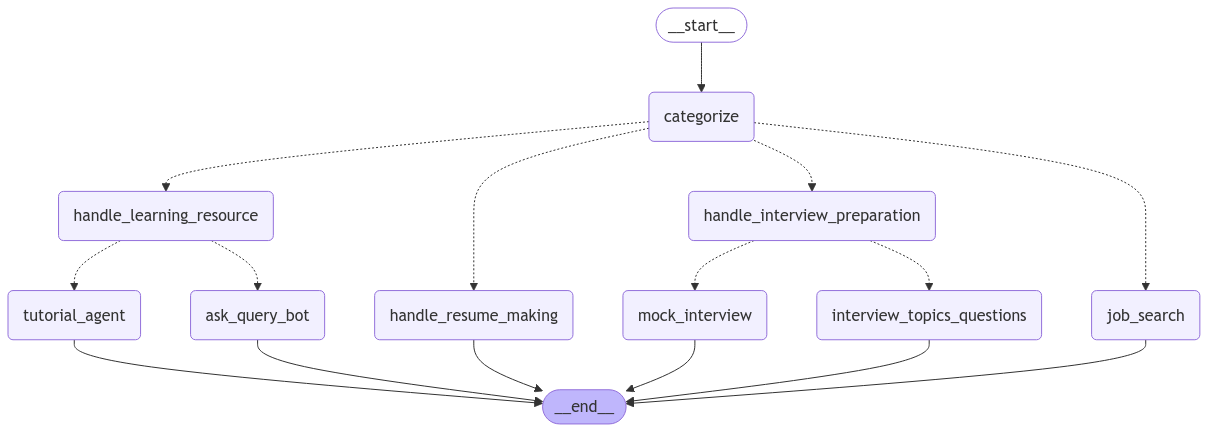

In [33]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,  # Uses Mermaid's API to generate the PNG image of the workflow graph
        )
    )
)

In [34]:
def run_user_query(query: str) -> Dict[str, str]:
    """Process a user query through the LangGraph workflow.
    
    Args:
        query (str): The user's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "response": results["response"]
    }